In [2]:
from hyperseti import hyperseti

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
from matplotlib import pyplot as plt
import numpy as np
import h5py as h5
import cupy as cp
import pandas as pd
from multiprocessing import Pool
import time

%matplotlib inline

In [4]:
file_name = "GBT_58210_31246_HIP93185_fine.h5"

[2021-05-09 02:00:49.666676] INFO: hyperseti.hyperseti: --- Boxcar size: 1 ---
[2021-05-09 02:00:49.676271] INFO: hyperseti.hyperseti: Dedopp setup time: 8.43ms
[2021-05-09 02:00:49.677411] INFO: hyperseti.hyperseti: Dedopp kernel time: 0.24ms
[2021-05-09 02:00:49.678596] INFO: hyperseti.hyperseti: Plotting 1
[2021-05-09 02:00:49.785540] INFO: hyperseti.hyperseti: Peak find time: 1.62ms
[2021-05-09 02:00:49.786641] INFO: hyperseti.hyperseti: Peak find memcopy: 0.13ms
[2021-05-09 02:00:50.495635] INFO: hyperseti.hyperseti: --- Boxcar size: 2 ---
[2021-05-09 02:00:50.498816] INFO: hyperseti.hyperseti: Filter time: 0.39ms
[2021-05-09 02:00:50.500078] INFO: hyperseti.hyperseti: Dedopp setup time: 2.56ms
[2021-05-09 02:00:50.501339] INFO: hyperseti.hyperseti: Dedopp kernel time: 0.15ms
[2021-05-09 02:00:50.502295] INFO: hyperseti.hyperseti: Plotting 2
[2021-05-09 02:00:50.589930] INFO: hyperseti.hyperseti: Peak find time: 1.63ms
[2021-05-09 02:00:50.591312] INFO: hyperseti.hyperseti: Peak f

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
10483,0.727053,1926.269528,4.099216e+09,180,1,2
5495,0.870551,1926.269514,2.950086e+09,195,6,1
0,-0.650521,1926.269514,2.916987e+09,36,6,1
11617,-0.994915,1926.269509,5.654359e+09,0,8,4
5496,0.860984,1926.269506,2.911102e+09,194,9,1
...,...,...,...,...,...,...
2687,-0.669654,1926.223791,2.766441e+09,34,16371,1
7923,0.947082,1926.223791,2.924981e+09,203,16371,1
2688,-0.794019,1926.223783,2.784090e+09,21,16374,1
9299,-0.727053,1926.223769,3.860490e+09,28,16379,2


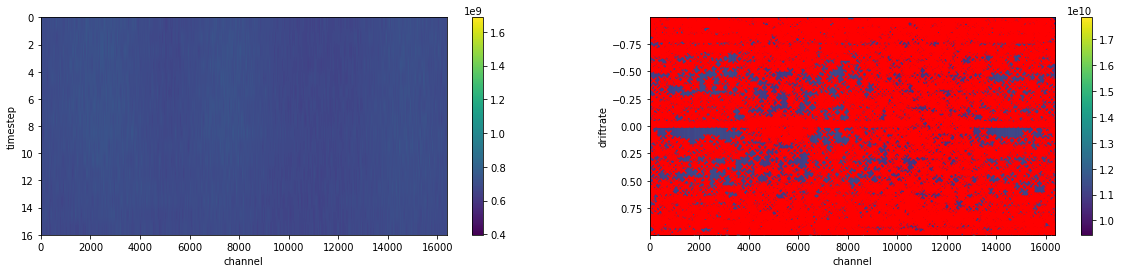

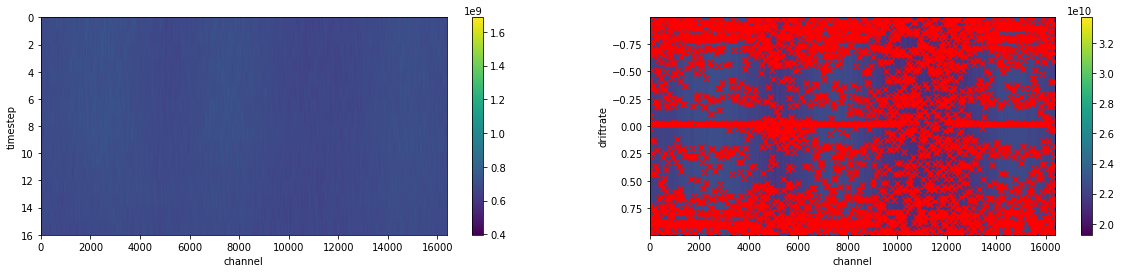

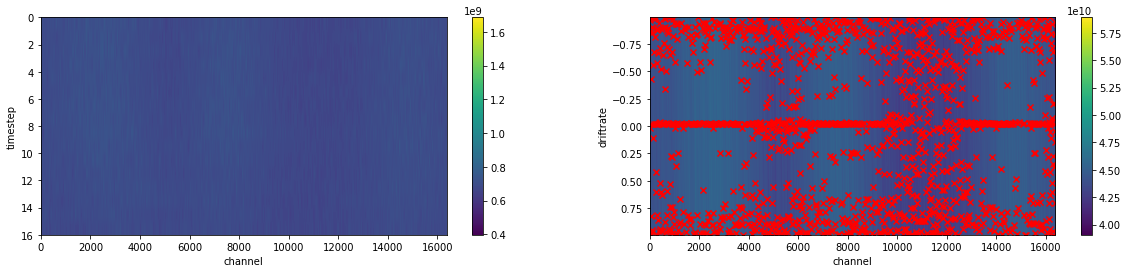

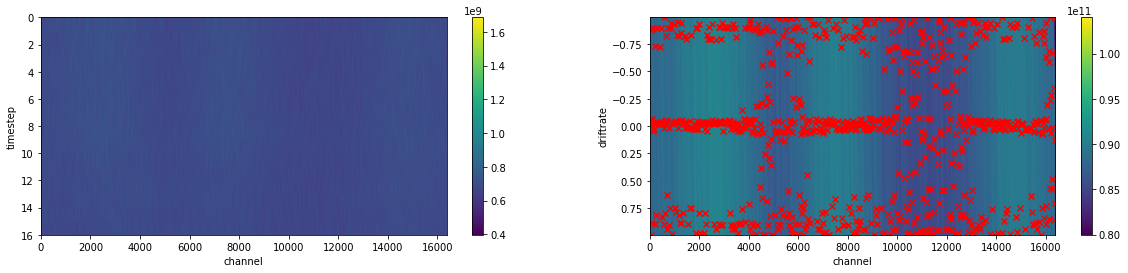

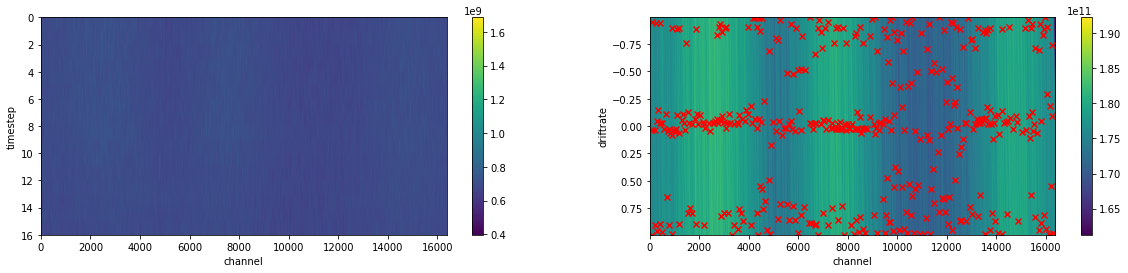

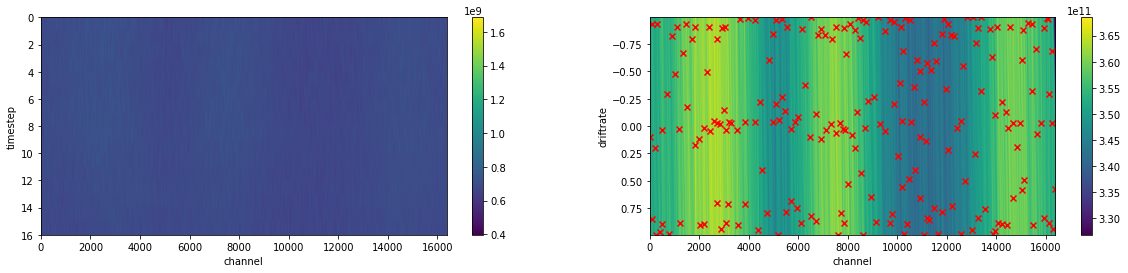

In [6]:
hyperseti.find_et_serial(file_name, gulp_size=2**14, ngulps=1, merge_boxcar_trials=True)

In [ ]:
hits = hyperseti.find_et_serial(file_name, gulp_size=2**13, limit=1, merge_boxcar_trials=False)

In [ ]:
hits.sort_values('snr', ascending=False)

In [ ]:
t0 = time.time()
save = hyperseti.merge_hits_gpu(hits)
t1 = time.time()
merged_hits = hits[save[0].get()]
print(f"Merge time: {(t1-t0)*1e3:2.2f}ms")

In [ ]:
merged_hits

In [ ]:
np.count_nonzero(save[0].get())

In [ ]:
cp.array(hits["snr"], dtype=cp.float32)

In [ ]:
for e in save[0]:
    print(e)

In [ ]:
hitlist = hits.sort_values("channel_idx", ascending=True)
split_arr = hitlist["channel_idx"]
splitter = np.expand_dims(np.arange(32) * (2**8), axis=0)
x = np.expand_dims(np.array(split_arr), axis=1)
inds = ((x > splitter-32) * (x < (splitter + (2**8)+32)))
selector = (((np.repeat(np.expand_dims(np.arange(len(hitlist)), axis=1), 32, axis=1))) * inds)
np.argmax(selector, axis=0)

In [ ]:
selector[inds != True] += len(hitlist)

In [ ]:
cp.full((len(hitlist),), True, dtype=cp.bool)

In [ ]:
hitlist

In [ ]:
np.argmin(selector, axis=0)

In [ ]:
selector

In [ ]:
y = hits["driftrate_idx"]
x = hits["channel_idx"]
plt.scatter(x, y)

In [ ]:
split_len = 2**9
splitter = cp.expand_dims(cp.arange(16) * split_len, axis=0)
print(splitter.shape)
splitter

In [ ]:
hits

In [ ]:
x_gpu = cp.expand_dims(cp.array(x), axis=1)
inds = ((x_gpu > splitter) * (x_gpu < (splitter + 400)))
len(hits[inds[:, 0].get()])

In [ ]:
# with Pool(16) as p:

In [ ]:
sub_lists = [hits[sub_inds] for sub_inds in inds.get().T]

In [ ]:
sub_lists[2]

In [ ]:
pd.concat(sub_lists)

In [ ]:
cluster_sizes = []
for i in range(len(hits)):
    p0 = hits.iloc[i]
    q = f"""(abs(driftrate_idx - {p0['driftrate_idx']}) <= boxcar_size + 1  |
                    abs(driftrate_idx - {p0['driftrate_idx']}) <= {p0['boxcar_size']} + 1)
                    & 
                    (abs(channel_idx - {p0['channel_idx']}) <= {p0['boxcar_size']} + 1| 
                    abs(channel_idx - {p0['channel_idx']}) <= boxcar_size + 1)"""
    q = q.replace('\n', '') # Query must be one line
    pq = hits.query(q)
    cluster_sizes.append(len(pq))

In [ ]:
_ = plt.boxplot(cluster_sizes)

In [ ]:
y = hits["driftrate_idx"]
x = hits["channel_idx"]
plt.scatter(x, y)

y = pq["driftrate_idx"]
x = pq["channel_idx"]
plt.scatter(x, y)

In [ ]:
f = h5.File(file_name, "r+")
f["data"].shape

In [ ]:
base = np.random.randint(0, 322961408 - 2**9)
d_slice = f["data"][:, 0, base:base + 2**9]
plt.imshow(d_slice, aspect="auto")

In [ ]:
print(base)

In [ ]:
from hyperseti.hyperseti import *
from skimage.exposure import equalize_adapthist

max_dd = 1

#peaks = create_empty_hits_table()    
ds = from_h5(file_name)
data_gen = ds.iterate_through_data({'frequency': 2**13})

for i in range(10000):
    d_arr = next(data_gen)

In [ ]:
search_count = 0
out = []
for i in range(np.random.randint(200)):
    d_arr = next(data_gen)
print(d_arr)
d = d_arr.data
f = d_arr.frequency
t = d_arr.time
md = {'fch1': f.val_start * f.units, 'df': f.val_step * f.units, 'dt': t.val_step * t.units}
# dedopp, metadata, hits = run_pipeline(d, md, max_dd)
# out.append(hits)
# logger.info(f"{len(hits)} hits found")

# dframe = pd.concat(out)
# dframe.to_csv(filename_out)
# t1 = time.time()
# print(f"## TOTAL TIME: {(t1-t0):2.2f}s ##\n\n")
plt.imshow(equalize_adapthist(d[:, 0, :] / d.max()), aspect="auto")
print(f, t)

In [ ]:
data = d
metadata = md
min_dd=None
threshold=50
min_fdistance=None
min_ddistance=None
n_boxcar=3
merge_boxcar_trials=False
apply_normalization=False

# t0 = time.time()
logger.debug(data.shape)
N_timesteps = data.shape[0]
_threshold = threshold * np.sqrt(N_timesteps)

# Apply preprocessing normalization
if apply_normalization:
    data = normalize(data, return_space='gpu')


peaks = create_empty_hits_table()

boxcar_trials = map(int, 2**np.arange(0, n_boxcar))
for boxcar_size in boxcar_trials:
    logger.info(f"--- Boxcar size: {boxcar_size} ---")
    dedopp, metadata = dedoppler(data, metadata, boxcar_size=boxcar_size,  boxcar_mode='sum',
                                 max_dd=max_dd, min_dd=min_dd, return_space='gpu')

    # Adjust SNR threshold to take into account boxcar size and dedoppler sum
    # Noise increases by sqrt(N_timesteps * boxcar_size)
    _threshold = threshold * np.sqrt(N_timesteps * boxcar_size)
    _peaks = hitsearch(dedopp, metadata, threshold=_threshold, min_fdistance=min_fdistance, min_ddistance=min_ddistance)

    if _peaks is not None:
        _peaks['snr'] /= np.sqrt(N_timesteps * boxcar_size)
        peaks = pd.concat((peaks, _peaks), ignore_index=True)

if merge_boxcar_trials:
    peaks = merge_hits(peaks)

# logger.info(f"Pipeline runtime: {(t1-t0):2.2f}s")

In [ ]:
peaks.head(3)

In [ ]:
from skimage.filters import gaussian
dedopp_cpu = dedopp.get()
show_dedopp = gaussian(dedopp_cpu, sigma=0)[:, 4700:5000]
# show_dedopp = dedopp_cpu[:, :200]

plt.imshow(equalize_adapthist(show_dedopp / np.max(show_dedopp)), aspect="auto")

In [ ]:
dedopp_cpu.shape

In [ ]:
dedopp

In [ ]:
a = cp.zeros((3,3))
a[1, 1] = 1
cp.roll(a, -1, axis=1)